## Solution description

My solution is based on undirected bipartite graph. One set of nodes is 'users', and the other set is 'movies'. Users are connected only with movies, and this connection means recommendation. In other words, if user is connected with a movie, then this movie is recommended to the user.


Model that I will use tries to predict new connections using LightGCN on embedded nodes summed with nodes features that passed through fully connected layer. More described model explanation can be found in 'Model Implementaion' section of [final_report.md](../reports/final_report.md)

My implementation is based on this [notebook](https://colab.research.google.com/drive/1VQTBxJuty7aLMepjEYE-d7E9kjo51CA1?usp=sharing#scrollTo=4p_Pj_D7t3Rk)


## Setup

First, we'll install the necessary packages.

In [14]:
import torch
from torch import Tensor
print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

2.1.0+cu118


'cuda'

In [15]:
%%capture
import os
os.environ['TORCH'] = torch.__version__

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Next, let's import all of the modules that we'll use in this notebook.

In [16]:
# Standard library imports
import random
import time

# Third-party imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_geometric.nn import LGConv
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

Lastly, we should double check that our environment is working as expected.

In [17]:
torch_geometric.__version__

'2.4.0'

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Random seeding

In [19]:
# Initialize seed constant
seed = 16

def set_seeds(seed):
    """
    Set seeds for reproducibility across different libraries.

    Args:
    - seed: Seed value for random number generation.

    Returns:
    None
    """

    # Set seeds for random number generation in various libraries
    random.seed(seed)  # Python's random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.backends.cudnn.deterministic = True  # PyTorch: deterministic behavior
    torch.backends.cudnn.benchmark = False  # PyTorch: disable benchmark mode

# Apply the seed setting
set_seeds(seed)

## Dataset and Preprocessing

For this tutorial, we’ll be using the [MovieLens 100K dataset](https://grouplens.org/datasets/movielens/), which contains 100,000 ratings by 943 users of 1682 items (movies). To ensure the quality of the dataset, each user has rated at least 20 movies.

We’ll focus on the interactions between users and items, in this case user ratings of movies, but the dataset also provides metadata about users and movies, such as user demographics and movie titles, release dates, and genres. T

The user ratings of movies form a bipartite graph, which we can apply graph machine learning methods to recommend new movies to users.


### Reading and preprocessing datasets

#### Ratings

In [20]:
# reading dataset with ratings
columns_name=['user_id','item_id','rating','timestamp']
df = pd.read_csv("../data/interim/ml-100k/u.data",sep="\t",names=columns_name)
# displaying its number of elements and 5 first rows to check the structure
print(len(df))
display(df.head(5))

100000


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


#### Genres list

In [21]:
# reading genres list
genres = pd.read_csv('../data/interim/ml-100k/u.genre', delimiter='|', index_col=1, names=['Genres'])
genres_list = genres['Genres'].values.tolist()

#### Movies information

##### Reading

In [22]:
# reading dataset with movies features
moveis_feateures = pd.read_csv("../data/interim/ml-100k/u.item",sep="|",
                               names=['item_id', 'movie title', 'release date', 'video release date', 'IMDb URL'] + genres_list, encoding='ISO-8859-1', index_col=0)

##### Dropping columns that are not used

In [23]:
# dropping features that we will not use
item_features_df = moveis_feateures.drop(['video release date', 'IMDb URL', 'movie title', 'release date'], axis=1)

##### Encoding

All features are given encode, so there is no need in this step

##### Displaying preprocessed dataset

In [24]:
# displaying updated dataset
item_features_df

,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
item_id,,,,,,,,,,,,,,,,,,,
1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1679,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1680,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


#### Users information

##### Reading

In [25]:
# reading dataset with user information
users = pd.read_csv('../data/interim/ml-100k/u.user', delimiter='|', names=['user_id', 'age', 'gender', 'occupation', 'zip code'], index_col=0)
users

,age,gender,occupation,zip code
user_id,,,,
1,24,M,technician,85711
2,53,F,other,94043
3,23,M,writer,32067
4,24,M,technician,43537
5,33,F,other,15213
...,...,...,...,...
939,26,F,student,33319
940,32,M,administrator,02215
941,20,M,student,97229


##### Dropping columns that are not used

In [26]:
# dropping user features that we will not use
users = users.drop(['age', 'zip code'], axis=1)
users

,gender,occupation
user_id,,
1,M,technician
2,F,other
3,M,writer
4,M,technician
5,F,other
...,...,...
939,F,student
940,M,administrator
941,M,student


##### Encoding features

In [27]:
# encode these features using one-hot encoder
user_features_df = pd.get_dummies(users, columns=['gender', 'occupation'])

##### Displaying preprocessed dataset

In [28]:
user_features_df

,gender_F,gender_M,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,occupation_executive,occupation_healthcare,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
940,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
941,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Dropping ratings below threshold


As mentioned earlier, my model is the bipartite graph with movies and users as nodes. The edge between user and movie shows the recommendation (this movie is recommended to this user).

Let's assume that all movies with rating greater or equal to 3 are suitable for this user, and it is ok to recommend them. We only want to use high ratings as interactions in order to predict which movies a user will enjoy watching next. Therefore, all ratings that below this dataframe will be dropped, since they are unused.

In [29]:
# Keep only ratings that greater or equal to 3
df = df[df['rating']>=3]
print(len(df))

82520


In [30]:
# Checking rating distribution
print("Rating Distribution")
df.groupby(['rating'])['rating'].count()

Rating Distribution


rating
3    27145
4    34174
5    21201
Name: rating, dtype: int64

### Train/Test split

Let's split dataframe in 80/20 ratio.

In [31]:
# Perform a 80/20 train-test split on the interactions in the dataset
train, test = train_test_split(df.values, test_size=0.2, random_state=seed)
train_df = pd.DataFrame(train, columns=df.columns)
test_df = pd.DataFrame(test, columns=df.columns)

In [32]:
# Displaying sizes of train and test dataframes
print("Train Size  : ", len(train_df))
print("Test Size : ", len(test_df))

Train Size  :  66016
Test Size :  16504


Since we performed the train/test randomly on the interactions, not all users and items may be present in the training set. We will relabel all of users and items to ensure the highest label is the number of users and items, respectively.

In [33]:
# Initialize LabelEncoders to encode user and item IDs into numerical indices
le_user = pp.LabelEncoder()  # LabelEncoder instance for user IDs
le_item = pp.LabelEncoder()  # LabelEncoder instance for item IDs

# Encode user IDs in the 'user_id' column of the 'train_df' DataFrame
# Transform user IDs into numerical indices and create a new column 'user_id_idx'
train_df['user_id_idx'] = le_user.fit_transform(train_df['user_id'].values)

# Encode item IDs in the 'item_id' column of the 'train_df' DataFrame
# Transform item IDs into numerical indices and create a new column 'item_id_idx'
train_df['item_id_idx'] = le_item.fit_transform(train_df['item_id'].values)

In [34]:
# Displaying transformed dataframe
train_df

,user_id,item_id,rating,timestamp,user_id_idx,item_id_idx
0,770,250,5,875971902,769,249
1,169,331,5,891268491,168,329
2,327,143,4,888251408,326,142
3,85,1101,4,879454046,84,1086
4,548,264,4,891043547,547,263
...,...,...,...,...,...,...
66011,807,177,4,892705191,806,176
66012,145,12,5,882182917,144,11
66013,602,748,3,888638160,601,740
66014,622,1078,3,882671160,621,1063


In [35]:
# Retrieve unique user IDs and item IDs from the training dataset
train_user_ids = train_df['user_id'].unique()  # Unique user IDs in the training dataset
train_item_ids = train_df['item_id'].unique()  # Unique item IDs in the training dataset

# Print the number of unique user IDs and item IDs in the training dataset
print(len(train_user_ids), len(train_item_ids))

# Filter the test dataset to include only user-item interactions present in the training dataset
test_df = test_df[
    (test_df['user_id'].isin(train_user_ids)) & \
    (test_df['item_id'].isin(train_item_ids))
]

# Print the length of the filtered test dataset
print(len(test))

943 1546
16504


In [ ]:
# Encode user IDs in the 'test_df' DataFrame using the LabelEncoder 'le_user'
# Transform user IDs into numerical indices and create a new column 'user_id_idx'
test_df['user_id_idx'] = le_user.transform(test_df['user_id'].values)

# Encode item IDs in the 'test_df' DataFrame using the LabelEncoder 'le_item'
# Transform item IDs into numerical indices and create a new column 'item_id_idx'
test_df['item_id_idx'] = le_item.transform(test_df['item_id'].values)

In [37]:
# Get the number of unique user indices ('user_id_idx') in the 'train_df' DataFrame
n_users = train_df['user_id_idx'].nunique()

# Get the number of unique item indices ('item_id_idx') in the 'train_df' DataFrame
n_items = train_df['item_id_idx'].nunique()

# Print the number of unique users and items in the training dataset
print("Number of Unique Users : ", n_users)
print("Number of Unique Items : ", n_items)

Number of Unique Users :  943
Number of Unique Items :  1546


### Merging user and movies features

Since our model will be a bipartite graph with movies and users as nodes, let's combine user and movie features. They become node features.

For user node all movie feature columns will be filled with 0 and user features will be filled according to one-hot encoded table

For movie node everything will be specularly: all user feature columns will be filled with 0 and movie features will be filled according to one-hot encoded table

In [38]:
# Get dataframe with user features associated to right user id index
# Number of elements in this dataframe is equel to number of users
data_with_user_features = pd.merge(train_df.drop(['rating', 'timestamp', 'item_id_idx', 'item_id'], axis=1), user_features_df, on='user_id').drop_duplicates(subset='user_id').reset_index()

# Get dataframe with movies features associated to right movie id index
# Number of elements in this dataframe is equel to number of movies
data_with_item_features = pd.merge(train_df.drop(['rating', 'timestamp', 'user_id_idx', 'user_id'], axis=1), item_features_df, on='item_id').drop_duplicates(subset='item_id').reset_index()

# Update item (movie) id index, so they will start from 'n_users'
data_with_item_features['item_id_idx'] += n_users

# Rename user_id_idx to node_idx for dataframe with user features, drop unused columns, sort by node_idx
data_with_user_features = data_with_user_features.rename(columns={'user_id_idx': 'node_idx'}).drop(['user_id', 'index'], axis=1).sort_values(by='node_idx')
# Rename item_id_idx to node_idx for dataframe with movies features, drop unused columns, sort by node_idx
data_with_item_features = data_with_item_features.rename(columns={'item_id_idx': 'node_idx'}).drop(['item_id', 'index'], axis=1).sort_values(by='node_idx')

In [39]:
# Merging dataframes with user and movie features, filling nan elements with 0
features_df = pd.merge(data_with_user_features, data_with_item_features, on='node_idx', how='outer').fillna(0)

In [40]:
# Displaying dataframe with combined features
features_df

,node_idx,gender_F,gender_M,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,occupation_executive,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2484,2484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2485,2485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2486,2486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2487,2487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's convert this data to torch Tensor, in order to use it further in the model

In [41]:
# Convertion of combined features dataframe to the tensor
features_tensor = torch.Tensor(features_df.drop(['node_idx'], axis=1).to_numpy()).to(device)

### Minibatch Sampling

Explain the scheme of minibatch positive and negative sample in some amount of prose.

We need to add `n_usr` to the sampled positive and negative items, since each node must have a unique id when using PyG.

In [42]:
import random
import pandas as pd
import torch

def data_loader(data, batch_size, n_usr, n_itm):
    """
    Data loader function to prepare a batch of user-item interactions for training.

    Args:
    - data (DataFrame): Input DataFrame containing user-item interactions.
    - batch_size (int): Size of the batch to be generated.
    - n_usr (int): Number of unique users.
    - n_itm (int): Number of unique items.

    Returns:
    - Tuple: Tuple containing tensors representing users, positive items, and negative items in the specified batch size.
    """

    def sample_neg(x):
      """
      Function to sample a negative item not interacted by a user.

      Args:
      - x (list): List of item indices interacted by a user.

      Returns:
      - int: Index of a negative item not interacted by the user.
      """
      while True:
          # Generate a random item index within the range of available items
          neg_id = random.randint(0, n_itm - 1)

          # Check if the randomly selected item is not interacted by the user
          if neg_id not in x:
              return neg_id

    # Group interactions by user IDs and collect associated item IDs into lists
    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

    # Create a list of indices representing users
    indices = [x for x in range(n_usr)]

    # Generate a batch of users randomly either by choice or by sampling from indices
    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users.sort()

    # Create a DataFrame with the selected users
    users_df = pd.DataFrame(users, columns=['users'])

    # Merge the DataFrame of user-item interactions with the selected users
    interected_items_df = pd.merge(interected_items_df, users_df, how='right', left_on='user_id_idx', right_on='users')

    # Sample positive items randomly from the grouped item interactions for each user
    pos_items = interected_items_df['item_id_idx'].apply(lambda x: random.choice(x))

    # Sample negative items (not interacted) using the sample_neg function for each user
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x))

    # Convert user indices and sampled item indices into PyTorch LongTensors and move to the specified device
    return (
        torch.LongTensor(list(users)).to(device),
        torch.LongTensor(list(pos_items.values)).to(device) + n_usr,
        torch.LongTensor(list(neg_items.values)).to(device) + n_usr,
    )

# Usage example:
data_loader(train_df, 32, n_users, n_items)


(tensor([  5,  10,  20,  22, 145, 225, 227, 232, 243, 259, 265, 291, 303, 309,
         317, 343, 370, 419, 426, 457, 480, 492, 616, 617, 650, 673, 682, 728,
         761, 808, 834, 874], device='cuda:0'),
 tensor([1093,  970,  995, 1155, 1249, 1092, 1040, 1445, 2002, 1291, 1225, 1116,
         1236, 1123, 1199, 1067, 1122, 1411, 2190, 1465, 1436, 1011, 1117, 1103,
         1268, 1533, 1213, 1242, 1228, 1249, 1228, 1153], device='cuda:0'),
 tensor([1886, 1871, 1077, 1279, 2375, 1930, 2433,  969, 1854, 1949,  971, 1915,
         2374, 1194, 1873, 2198, 1103, 1965, 2283,  989, 1237, 2391, 1418, 1774,
         1699, 1010, 2047, 1031, 2293, 2274, 1762, 2179], device='cuda:0'))

## Edge Index

PyG represents graphs as sparse lists of node pairs. Since our graph is undirected, we need to include each edge twice, once for the edges from the users to the items and vice-versa.

Similar to above, we add `n_users` to the item tensor to ensure that every node in the graph has a unique identifier.

In [43]:
# Convert user indices and item indices into PyTorch LongTensors
u_t = torch.LongTensor(train_df.user_id_idx)  # Tensor for user indices
i_t = torch.LongTensor(train_df.item_id_idx) + n_users  # Tensor for item indices

# Construct edge index tensor for training data
train_edge_index = torch.stack((
    torch.cat([u_t, i_t]),  # Concatenate user indices and item indices
    torch.cat([i_t, u_t])   # Concatenate item indices and user indices (reversed)
)).to(device)  # Move the tensor to the specified device (e.g., CPU or GPU)

Let's confirm that the first and last edges match the middle two edges, but with the order of nodes swapped.

In [44]:
train_edge_index[:,-1], train_edge_index[:, 0]

(tensor([989,  59], device='cuda:0'), tensor([ 769, 1192], device='cuda:0'))

In [45]:
train_edge_index[:, len(train)-1], train_edge_index[:, len(train)]

(tensor([ 59, 989], device='cuda:0'), tensor([1192,  769], device='cuda:0'))

## Model Architecture

### LightGCN Convolutional Layer

The LightGCN architecture is governed by the following rules:

$$e_{u}^{(k+1)} = \sum\limits_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}}e^{(k)}_i$$

$$e_{i}^{(k+1)} = \sum\limits_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}}e^{(k)}_u$$
In essence, the embedding for each node after a single LightGCN layer is the sum of the synthetic normalized embeddings of it's neighbors before the layer.

Notice how each node has an initial feature vector corresponding to a one-hot encoding at the index of their id.

As we expected, node 0 received messages (and so has non-zero features at the corresponding indicies) from nodes 2 and 3. We can easily verify that nodes 1, 2, 3, and 4 also received messages from their precisely neighbors.

### Recommender System GNN

In [46]:
class RecSysGNN(nn.Module):
    def __init__(
        self,
        latent_dim,
        num_layers,
        num_users,
        num_items,
        feat_dim,
        dropout=0.1
    ):
        """
        Initialize the RecSysGNN model.

        Args:
        - latent_dim (int): The dimensionality of the latent space for embeddings.
        - num_layers (int): The number of LGConv layers.
        - num_users (int): The total number of users.
        - num_items (int): The total number of items.
        - feat_dim (int): The dimensionality of additional features.
        - model: The type of model.
        - dropout (float, optional): Dropout probability (default: 0.1).
        """
        super(RecSysGNN, self).__init__()

        self.embedding = nn.Embedding(num_users + num_items, latent_dim)
        self.feat_embedding = nn.Linear(feat_dim, latent_dim)

        # Create a list of LGConv layers for message passing
        self.convs = nn.ModuleList([
            LGConv() for _ in range(num_layers)
        ])

        # Initialize parameters
        self.init_parameters()

    def init_parameters(self):
        """
        Initialize model parameters.
        """
        # Initialize weights of the embedding layer with a normal distribution
        nn.init.normal_(self.embedding.weight, std=0.1)

    def forward(self, edge_index, feats_tensor):
        """
        Forward pass of the RecSysGNN model.

        Args:
        - edge_index: Edge index tensor.
        - feats_tensor: Tensor containing additional features.

        Returns:
        - out: Final node embeddings after message passing.
        """
        emb = self.embedding.weight

        # Obtain embeddings for user and item features
        feats = self.feat_embedding(feats_tensor)

        # Add additional feature embeddings to the initial node embeddings
        emb = emb + feats
        embs = [emb]

        # Perform message passing through LGConv layers
        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        # Aggregate node embeddings to get the final output
        out = torch.mean(torch.stack(embs, dim=0), dim=0)

        return out

    def encode_minibatch(self, users, pos_items, neg_items, edge_index, feats_tensor):
        """
        Encode a minibatch of users, positive items, and negative items.

        Args:
        - users: Tensor of user indices.
        - pos_items: Tensor of positive item indices.
        - neg_items: Tensor of negative item indices.
        - edge_index: Edge index tensor.
        - feats_tensor: Tensor containing additional features.

        Returns:
        - Embeddings of users, positive items, and negative items.
        """
        out = self(edge_index, feats_tensor)
        return (
            out[users],
            out[pos_items],
            out[neg_items],
        )


## Loss function and metrics

We implement both the Bayesian Personalized Ranking loss function for a single minibatch of users, positive items, and negative items, as well as the precision@K and recall@K metrics.

In [47]:
def compute_bpr_loss(users_emb, pos_emb, neg_emb):
    """
    Compute Bayesian Personalized Ranking (BPR) loss.

    Args:
    - users_emb: Embeddings of users.
    - pos_emb: Embeddings of positive items.
    - neg_emb: Embeddings of negative items.

    Returns:
    - bpr_loss: Calculated BPR loss.
    """
    # Compute dot products between user and item embeddings
    pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
    neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

    # Calculate BPR loss using softplus function
    bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

    return bpr_loss


In [48]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
    """
    Compute evaluation metrics for recommendation system.

    Args:
    - user_Embed_wts: Embedding weights for users.
    - item_Embed_wts: Embedding weights for items.
    - n_users: Number of unique users.
    - n_items: Number of unique items.
    - train_data: Training dataset.
    - test_data: Test dataset.
    - K: Number of top recommendations.

    Returns:
    - recall: Mean recall value.
    - precision: Mean precision value.
    """
    # Get unique user IDs from test data
    test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())

    # Compute the score of all user-item pairs
    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts, 0, 1))

    # Create dense tensor of all user-item interactions from the training data
    i = torch.stack((
        torch.LongTensor(train_df['user_id_idx'].values),
        torch.LongTensor(train_df['item_id_idx'].values)
    ))
    v = torch.ones((len(train_df)), dtype=torch.float64)
    interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items)).to_dense().to(device)

    # Mask out training user-item interactions from metric computation
    relevance_score = torch.mul(relevance_score, (1 - interactions_t))

    # Compute top scoring items for each user
    topk_relevance_indices = torch.topk(relevance_score, K).indices
    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),
                                             columns=['top_indx_' + str(x + 1) for x in range(K)])
    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[
        ['top_indx_' + str(x + 1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID', 'top_rlvnt_itm']]

    # Measure overlap between recommended (top-scoring) and held-out user-item interactions
    test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    metrics_df = pd.merge(test_interacted_items, topk_relevance_indices_df, how='left', left_on='user_id_idx',
                          right_on=['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx,
                                                                               metrics_df.top_rlvnt_itm)]

    # Calculate recall and precision metrics
    metrics_df['recall'] = metrics_df.apply(lambda x: len(x['intrsctn_itm']) / len(x['item_id_idx']), axis=1)
    metrics_df['precision'] = metrics_df.apply(lambda x: len(x['intrsctn_itm']) / K, axis=1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean()

## Train and evaluate models

### Model constants intialization

In [49]:
latent_dim = 64
n_layers = 3

EPOCHS = 50
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005
K = 20

In [50]:
num_user_features = user_features_df.shape[1]
num_item_features = item_features_df.shape[1]

### Function for train and evaluate

In [51]:
def train_and_eval(model, optimizer, train_df):
    """
    Trains the recommendation model and evaluates its performance.

    Args:
        model (torch.nn.Module): The recommendation model.
        optimizer: Optimizer used for training.
        train_df (pandas.DataFrame): Training dataset.

    Returns:
        bpr_loss_list_epoch (list): List of BPR losses per epoch.
        recall_list (list): List of recall values per epoch.
        precision_list (list): List of precision values per epoch.
    """

    # Initialize lists to track metrics per epoch
    bpr_loss_list_epoch = []
    recall_list = []
    precision_list = []

    # Iterate through epochs
    for epoch in tqdm(range(EPOCHS)):
        # Calculate the number of batches
        n_batch = int(len(train) / BATCH_SIZE)
        bpr_loss_list = []

        # Set model to train mode
        model.train()

        # Iterate through batches
        for batch_idx in range(n_batch):
            optimizer.zero_grad()

            # Obtain data for the current batch
            users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items)
            users_emb, pos_emb, neg_emb = model.encode_minibatch(users, pos_items, neg_items, train_edge_index,
                                                                 features_tensor)

            # Compute Bayesian Personalized Ranking (BPR) loss
            bpr_loss = compute_bpr_loss(users_emb, pos_emb, neg_emb)

            # Backpropagation and optimization
            bpr_loss.backward()
            optimizer.step()

            bpr_loss_list.append(bpr_loss.item())

        # Set model to evaluation mode
        model.eval()
        with torch.no_grad():
            # Obtain model outputs for evaluation
            out = model(train_edge_index, features_tensor)
            final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))

            # Calculate evaluation metrics (recall and precision)
            test_topK_recall, test_topK_precision = get_metrics(final_user_Embed, final_item_Embed, n_users, n_items,
                                                               train_df, test_df, K)

        # Append metrics for current epoch to respective lists
        bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list), 4))
        recall_list.append(round(test_topK_recall, 4))
        precision_list.append(round(test_topK_precision, 4))

    # Return aggregated metrics lists
    return (
        bpr_loss_list_epoch,
        recall_list,
        precision_list
    )

### Train and eval LightGCN

#### Model definition

In [52]:
# Create LightGCN model instance
lightgcn = RecSysGNN(
    latent_dim=latent_dim,
    num_layers=n_layers,
    num_users=n_users,
    num_items=n_items,
    feat_dim=num_user_features + num_item_features,
)
lightgcn.to(device)  # Move model to device (e.g., GPU if available)

# Define Adam optimizer for training the model
optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)

# Print the size of learnable parameters in the model
print("Size of Learnable Embedding : ", [x.shape for x in list(lightgcn.parameters())])

Size of Learnable Embedding :  [torch.Size([2489, 64]), torch.Size([64, 42]), torch.Size([64])]


#### Train and evaluate

In [53]:
# Train and evaluate the LightGCN model
light_bpr, light_recall, light_precision = train_and_eval(lightgcn, optimizer, train_df)

  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-48-e4a0fc6b1f8b>:30: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items)).to_dense().to(device)


Saving obtained model

In [ ]:
# Save the entire model
torch.save(lightgcn, '../models/lightgcn.pth')

#### Visualize obtained results

##### Feature weights visualization

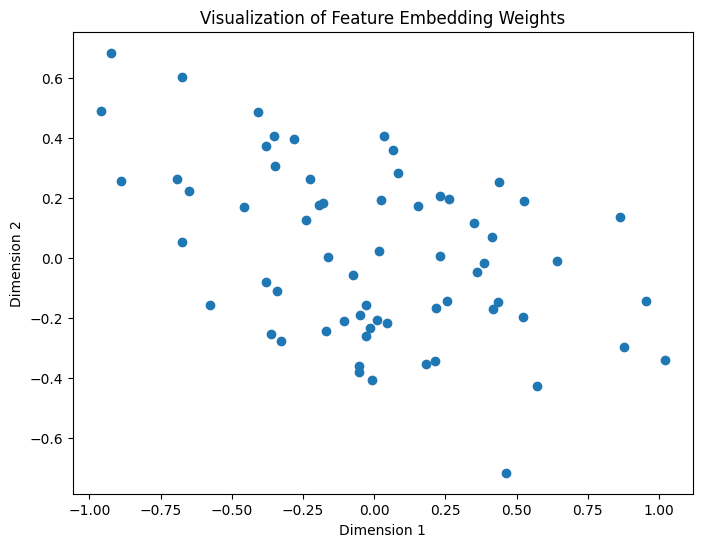

In [77]:
# Extracting the feature embedding weights from the model
feature_embedding_weights = lightgcn.feat_embedding.weight.data.cpu()

# Visualizing the weights (assuming a 2D embedding)
plt.figure(figsize=(8, 6))
plt.scatter(feature_embedding_weights[:, 0], feature_embedding_weights[:, 1])
plt.title('Visualization of Feature Embedding Weights')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
# Saving figure
plt.savefig('../reports/figures/Weights scatter.png')
# Displaying figure
plt.show()

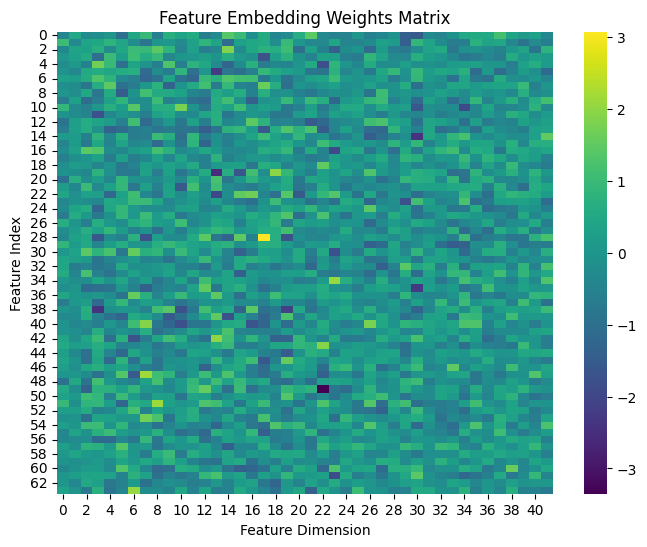

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extracting the feature embedding weights from the model
feature_embedding_weights = lightgcn.feat_embedding.weight.data.cpu().numpy()

# Plotting the feature embedding weights as a matrix
plt.figure(figsize=(8, 6))
sns.heatmap(feature_embedding_weights, cmap='viridis')
plt.title('Feature Embedding Weights Matrix')
plt.xlabel('Feature Dimension')
plt.ylabel('Feature Index')
# Saving figure
plt.savefig('../reports/figures/Weights heatmap.png')
# Displaying figure
plt.show()

##### Training Bayesian Personalized Ranking (BPR) loss visualization

In [54]:
# Create a list of epochs from 1 to EPOCHS
epoch_list = [(i+1) for i in range(EPOCHS)]

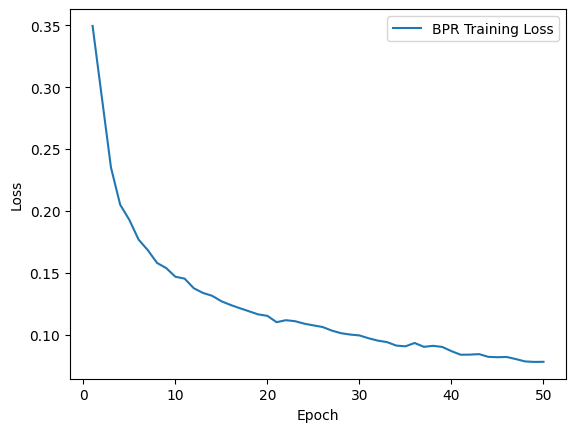

In [58]:
# Plotting BPR Training Loss against Epoch
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')

# Labeling the axes
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Adding a legend to the plot
plt.legend()
# Saving figure
plt.savefig('../reports/figures/BPR Training Loss.png')
# Displaying figure
plt.show()

##### Precision and Recall visualization

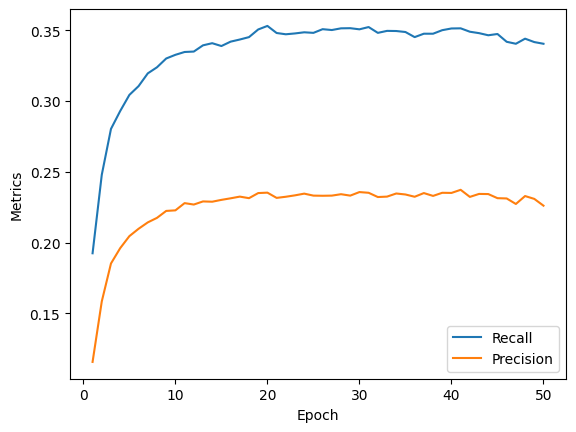

In [59]:
# Plotting Recall and Precision against Epoch
plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, light_precision, label='Precision')

# Labeling the axes
plt.xlabel('Epoch')
plt.ylabel('Metrics')

# Adding a legend to the plot
plt.legend()
# Saving figure
plt.savefig('../reports/figures/Recall Precision.png')
# Displaying figure
plt.show()

In [57]:
# Best precision and recall
max(light_precision), max(light_recall)

(0.2373, 0.353)

## Paper References

1. Harper, F. Maxwell, and Konstan, Joseph A. “The MovieLensDatasets: History and Context.” ACM Transactions on Interactive Intelligence Systems (TiiS) 5, 4. 2015.
2. He, Xiangnan, et al. “LightGCN: Simplifying and powering graph convolution network for recommendation.” Proceedings of the 43rd International ACM SIGIR Conference on Research and Development in Information Retrieval. 2020.
